# 서울시 부동산 매매가격 분석

### (1) 주제 선정 이유
- 서울시 부동산 가격 정보를 한눈에 비교하고 직관적으로 볼 수 있었으면 좋겠다는 생각이 들어서 이 프로젝트를 진행하게 되었습니다.<br>

### (2) 데이터 수집과 가공
- github에서 서울시 구별 법정동 코드를 수집해서 텍스트파일로 저장
https://gist.githubusercontent.com/FinanceData/4b0a6e1818cea9e77496e57b84bb4565/raw/b682e526c7e9ebd1c30f688b789aa018f396e1c9/%25EB%25B2%2595%25EC%25A0%2595%25EB%258F%2599%25EC%25BD%2594%25EB%2593%259C%25EC%25A0%2584%25EC%25B2%25B4%25EC%259E%2590%25EB%25A3%258C.txt

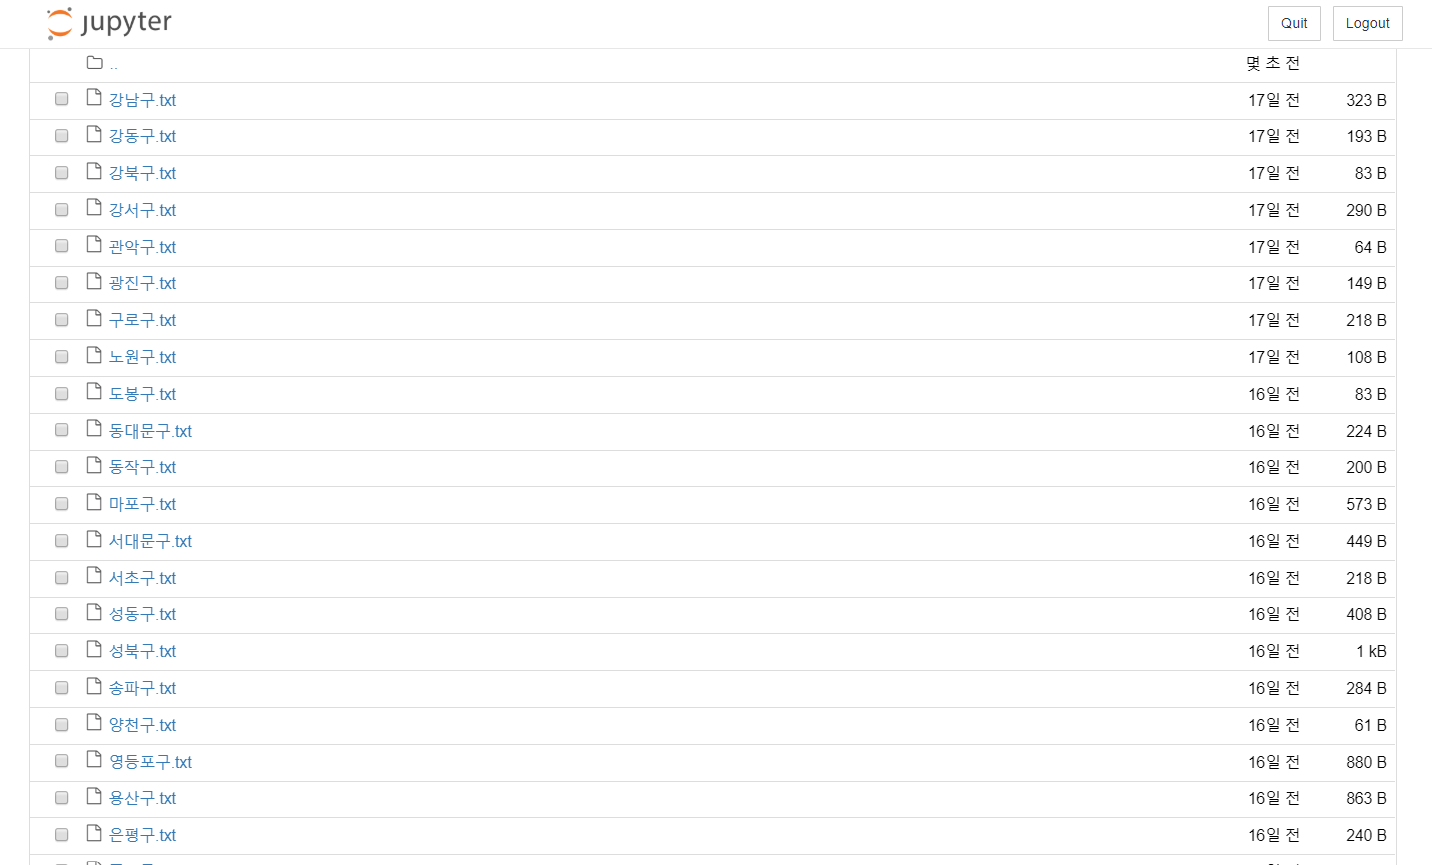

- 지역별 코드를 리스트 형태로 정리 (지역코드.ipynb)<br>
http://localhost:8890/notebooks/term_project/%EC%86%8C%EC%9C%B5%EA%B0%9C%EB%A1%A0%20%ED%85%80%ED%94%84/%EC%A7%80%EC%97%AD%EC%BD%94%EB%93%9C.ipynb<br>

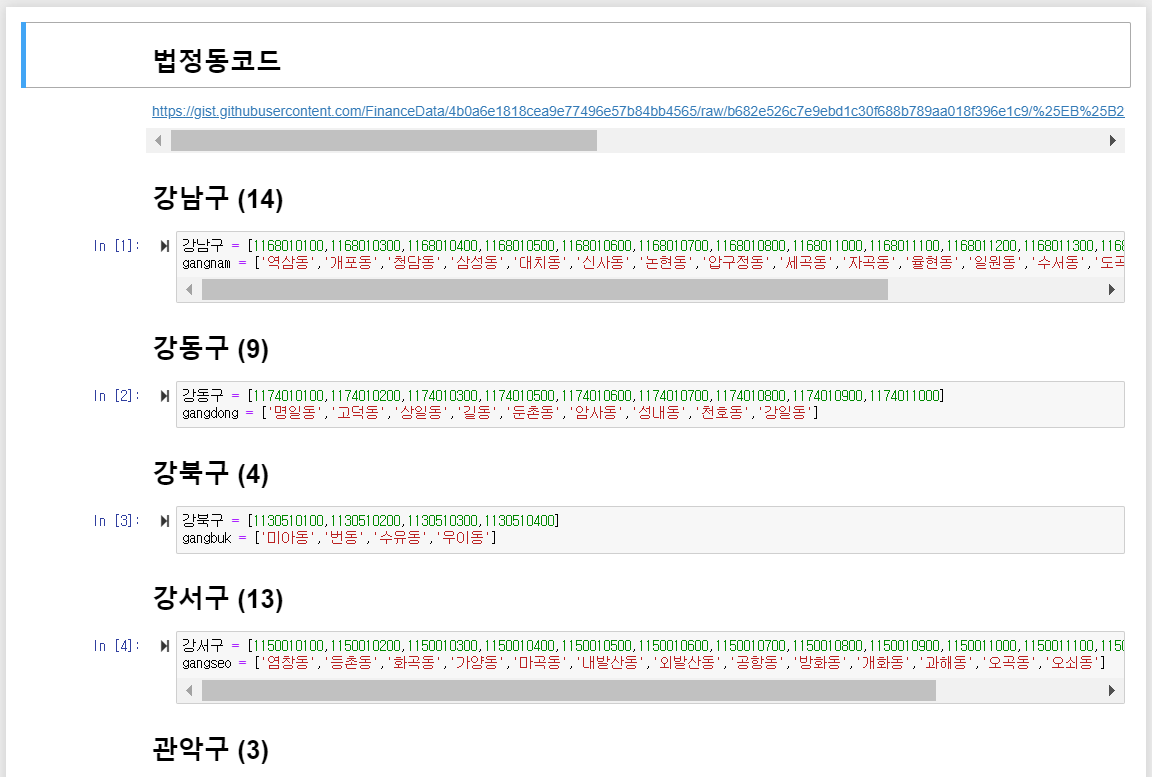

- 각 구별로 데이터를 수집
> 강남구

In [3]:
강남구 = [1168010100,1168010300,1168010400,1168010500,1168010600,1168010700,1168010800,1168011000,1168011100,1168011200,1168011300,1168011400,1168011500,1168011800]
gangnam = ['역삼동','개포동','청담동','삼성동','대치동','신사동','논현동','압구정동','세곡동','자곡동','율현동','일원동','수서동','도곡동']

In [4]:
#필요한 모듈들을 import 합니다.
import requests
from bs4 import BeautifulSoup
import pandas as pd

#변수 리스트 설정(이름,평수,가격,평당가격)
names = []
areas = []
prices = []
area_per_price = []

#강남구에 해당하는 데이터 수집
for area_code in 강남구:
    
    url = 'https://hogangnono.com/region/{}'.format(area_code) #url을 area_code를 이용하여 반복문으로 한번에 모두 가져옵니다.
    source_code = requests.get(url)
    plain_text = source_code.text
    soup = BeautifulSoup(plain_text)
    name = []
    for pages in soup.findAll('li'):    # 아파트 이름을 가져옵니다
        for link in pages('h5',{'class':'name'}):
            data = link.text        
            name.append(data)
    area = []    
    for pages in soup.findAll('li'):    # 아프트 면적을 가져옵니다
        for link in pages('span',{'class':'area'}):
            data = link.text        
            area.append(data)
    price = []
    for pages in soup.findAll('li'):    #아파트 가겨을 가져옵니다
        for link in pages('span',{'class':'price'}):
            data = link.text        
            price.append(data)
            
    index_dash = [i for i, n in enumerate(price) if n == '-'] # 아파트 가격이 '-' 로 나와있는 아파트들의 index를 찾아냅니다
    for i in index_dash[::-1]: # '-'로 나와있는 아파트를 리스트에서 지웁니다
        del(name[i])
        del(area[i])
        del(price[i])
    
    new_name = [] # 아파트 이름 앞에 동 이름을 제거합니다
    for k in name:
        k_idx = k.find(' ')
        k = k[k_idx+1:]
        new_name.append(k)
        
    
    int_area = []
    for l in area: # 아파트 면적을 integer로 바꿔줍니다
        per = l[:-1]
        int_area.append(int(per))
    
    new_price = []
    for j in price: # 아파트 가격을 integer 로 바꿔줍니다

        if '억'in j:
            if len(j)>4:
                y_idx = j.find('억')
                pri = j[0:y_idx]
                pri1 = j[y_idx+1:]
                pri2 = pri1.replace(',','')
                j = ((int(pri)*10000)+(int(pri2)))*10000
                new_price.append(j)
            else:
                j = j.replace('억','')
                j = int(j)*100000000
                new_price.append(j)

        else:
            j = j.replace(',','')
            j = int(j)*10000
            new_price.append(j)
            
    per_price = [] # 평당 가격을 계산합니다
    for a in range(len(new_price)):
        perp = new_price[a]/int_area[a]
        per_price.append(round(perp))
        
    
# lists in lists 로 저장합니다
    names.append(new_name)
    areas.append(int_area)
    prices.append(new_price)
    area_per_price.append(per_price)
    
amean = []

for i in range(len(gangnam)): # 동별로 평당가격의 mean을 구해줍니다
    if len(area_per_price[i])>0:
        mean = sum(area_per_price[i])/len(area_per_price[i])
        amean.append(round(mean))
        
    else:
        amean.append(0)
        
# pandas DataFrame을 이용한 시각화
kk = {'dong':강남구,'per price':amean}
df = pd.DataFrame(kk,index = gangnam)
df

,dong,per price
역삼동,1168010100,53803304
개포동,1168010300,52430570
청담동,1168010400,41973418
삼성동,1168010500,38476343
대치동,1168010600,39333962
신사동,1168010700,29941603
논현동,1168010800,27085193
압구정동,1168011000,70984225
세곡동,1168011100,22379926
자곡동,1168011200,21942683


In [5]:
df.to_csv('gangnamgu.csv') # csv파일로 저장합니다

> 나머지 동들 

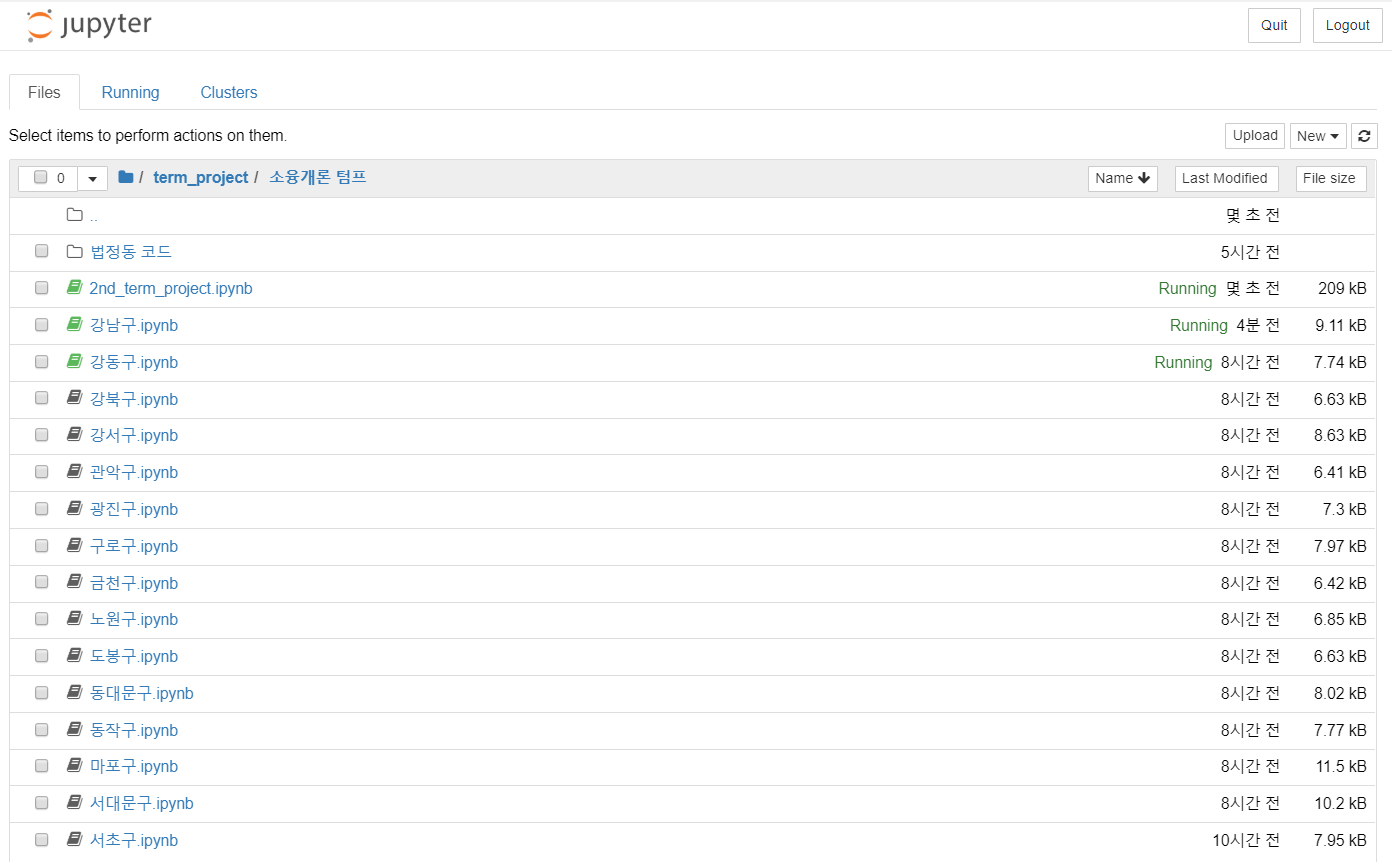

### (3) 데이터 시각화

- 지도 데이터 시각화를 위한 folium 설치
- github에서 서울시 구별 지도 데이터 수집 및 가공(json)
- choropleth를 이용한 구별 가격 비교 시각화

In [6]:
!pip install folium

In [7]:
# 서울시 구별 코드 정리
서울시 = ['jongnogu','junggu','yongsangu','seongdonggu','gwangjingu','dongdaemungu','jungnanggu','seongbukgu','gangbukgu','dobonggu','nowongu', 'eunpyeonggu','seodaemungu','mapogu','yangcheongu','gangseogu','gurogu','geumcheongu','yeongdeungpogu','dongjakgu','gwanakgu','seochogu','gangnamgu','songpagu','gangdonggu']
seoulsi = [11010,11020,11030,11040,11050,11060,11070,11080,11090,11100,11110,11120,11130,11140,11150,11160,11170,11180,11190,11200,11210,11220,11230,11240,11250]

In [8]:
# pandas 모듈 불러오기
import pandas as pd

pprice = []   #구별 평균가격
gus = []   #각 구에 속하는 동별 평당가격(list in list)
for gu in 서울시:
    gudeul = []
    x = pd.read_csv(str(gu)+'.csv')
    new_list = x['per price'].tolist()
    for k in new_list:
        if k == 0:
            del new_list[k]
        else:
            gudeul.append(k)
    gus.append(gudeul)

for i in range(len(gus)):
    pprice.append(round(sum(gus[i])/len(gus[i])))

# pandas를 이용한 데이터 시각화
Seoul = {'area code':seoulsi,'price':pprice}
df = pd.DataFrame(Seoul,index = 서울시)
df

,area code,price
jongnogu,11010,17315259
junggu,11020,16565786
yongsangu,11030,26809288
seongdonggu,11040,24652879
gwangjingu,11050,18723442
dongdaemungu,11060,17942011
jungnanggu,11070,34340195
seongbukgu,11080,17728487
gangbukgu,11090,13006466
dobonggu,11100,12687343


In [9]:
df.to_csv('seoul.csv')   #csv파일로 저장

In [10]:
# 데이터 시각화에 필요한 json, folium, pandas 모듈 불러오기
import json
import folium
import pandas as pd

#github에서 서울시 지도데이터 수집
geo_path = 'seoul_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path,encoding = 'utf-8'))
geo_str

#folium.Map에 사용할 데이터 정리
guData = pd.read_csv('seoul.csv', header = 0)
for i in range(len(guData)):
    guData.loc[i,'area code'] = str(guData.loc[i,'area code'])
    
guData

,Unnamed: 0,area code,price
0,jongnogu,11010,17315259
1,junggu,11020,16565786
2,yongsangu,11030,26809288
3,seongdonggu,11040,24652879
4,gwangjingu,11050,18723442
5,dongdaemungu,11060,17942011
6,jungnanggu,11070,34340195
7,seongbukgu,11080,17728487
8,gangbukgu,11090,13006466
9,dobonggu,11100,12687343


In [12]:
# folium을 이용한 구별 가격 비교 시각화
seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles = 'cartodbpositron')
seoul_map.choropleth(geo_data = geo_str,
                    data = guData,
                    columns = ['area code','price'],
                    fill_color = 'BuPu',
                    key_on = 'properties.code',
                    highlight=True,
                    fill_opacity = 1, line_opacity = 1,
                    legend_name='price')

seoul_map.save('seoul_map.html')
seoul_map